In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config_aimet
import dataset_dfire
import datasets_aimet
import models_aimet_medium_fasdd
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Define Matplotlib Style

In [3]:
#mpl.style.use('seaborn-v0_8')

# Logger

In [4]:
log_path = config_aimet.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tModels imported after AIMET processing.\n' +
            '\t\tPruning after SVD.\n' +
            '\t\tSVD after Pruning.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\tBit width of Big Layers separated.\n' +
            '\tQuantIdentity with Uint8Act added and constant scale factor.\n' +
            '\tWeights with Per Channel Quant.\n' +
            '\tIntBias, Internal Scale with FixedPoint.\n' +
            '\tConv341 defined as big layer.\n' +
            f'\tFixed Point: {config_aimet.FIXED_POINT}.\n' +
            f'\tWeights bit width = {config_aimet.WEIGHTS_BIT_WIDTH}.\n' +
            f'\tBig Layers Weights bit width = {config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH}.\n' +
            f'\tActivations bit width = {config_aimet.ACTIVATIONS_BIT_WIDTH}.\n' +
            f'\tBias bit width = {config_aimet.BIAS_BIT_WIDTH}.\n' +
            f'\t{config_aimet.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [5]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config_aimet.IMG_H, config_aimet.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [6]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset_dfire.DFireDataset(
    img_h=config_aimet.IMG_H, 
    img_w=config_aimet.IMG_W, 
    img_dir=config_aimet.val_imgs, 
    label_dir=config_aimet.val_labels, 
    num_classes=config_aimet.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

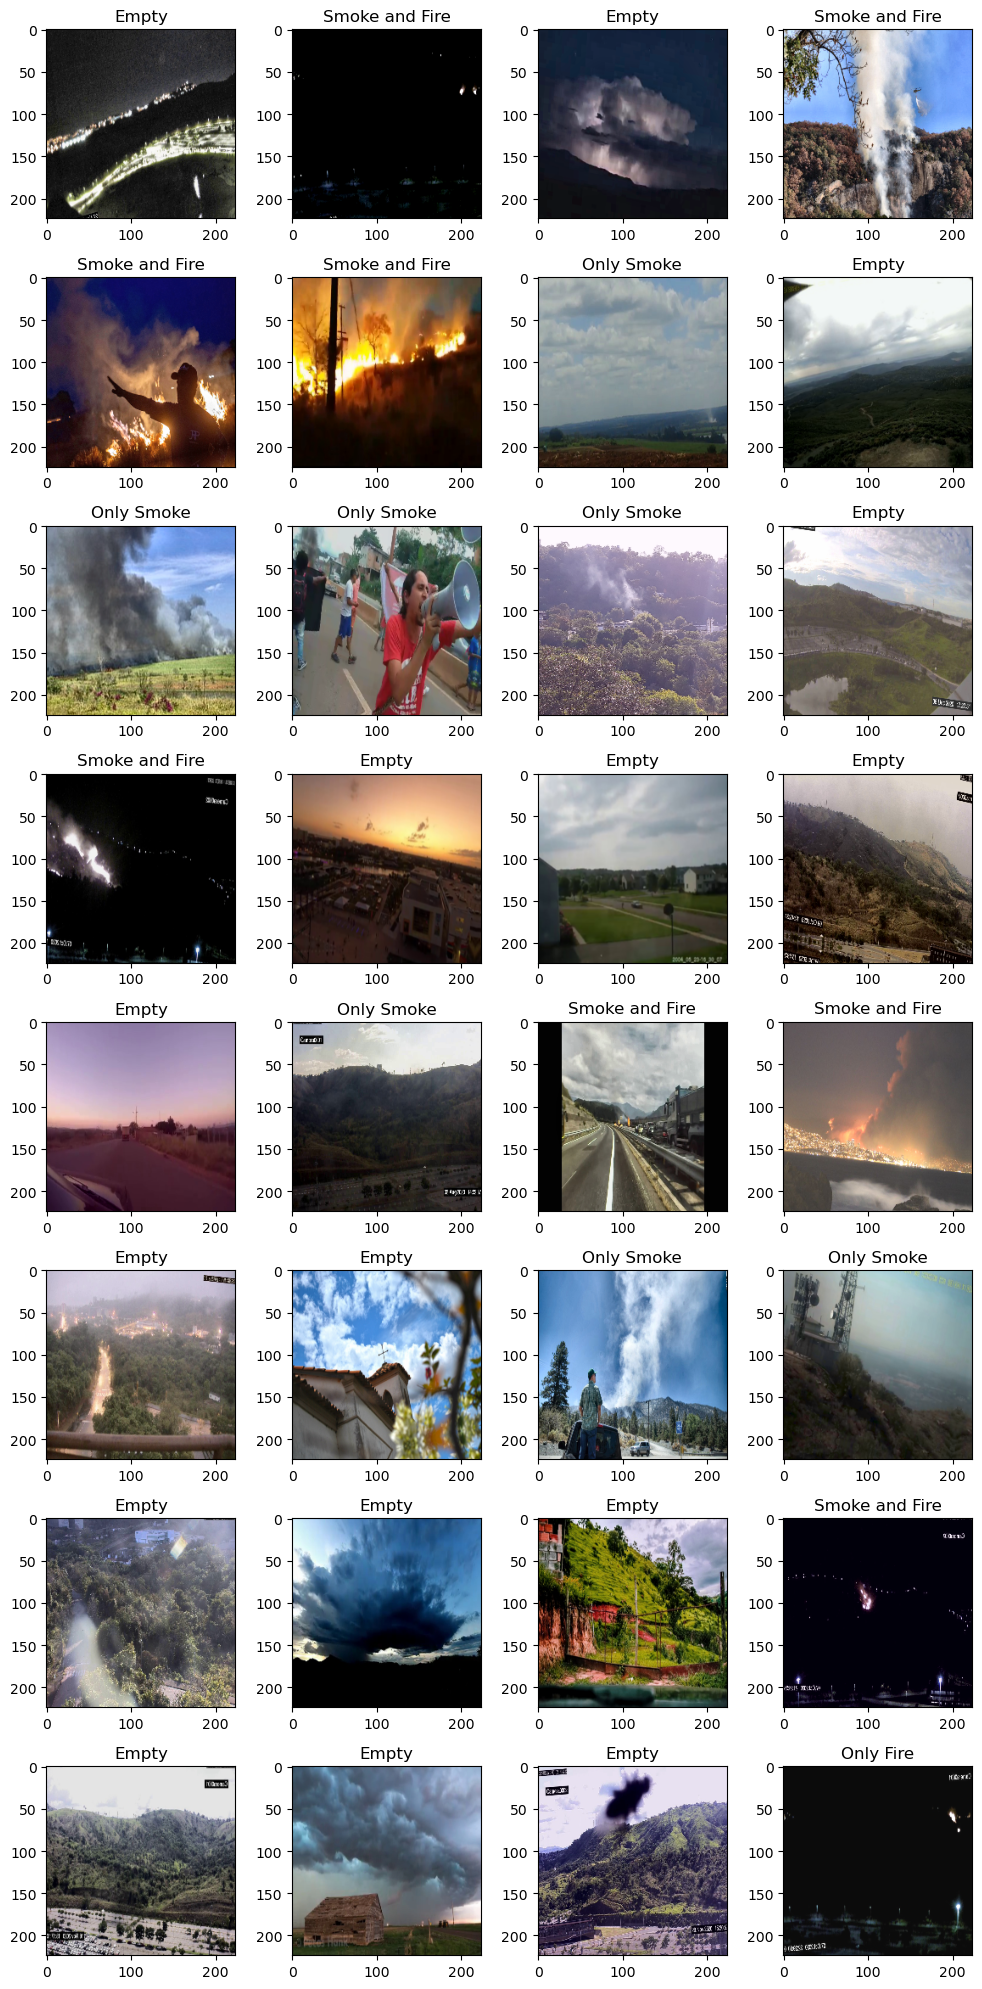

In [7]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [8]:
train_loader = datasets_aimet.get_train_loader()
val_loader = datasets_aimet.get_val_loader()


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763

Train DFire dataset len: 17221

TRAIN FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 5994
DFire only smoke images: 2541
DFire only fire images: 105
DFire smoke and fire images: 3911

Train FASDD UAV dataset len: 12551

TRAIN FASDD CV dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 19600
DFire only smoke images: 11708
DFire only fire images: 6276
DFire smoke and fire images: 10076

Train FASDD CV dataset len: 47660

Concatenate Train DFire and FASDD UAV datasets
Train dataset len: 29772
Concatenate with FASDD CV dataset
Train dataset len: 77432

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884
Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate wit

# Models Setup

In [9]:
if config_aimet.MODEL == "BED":
    
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models_aimet_medium_fasdd.ORIGINAL_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)  
    
    print("Using Fixed Point Quantizers without BN")
    logger.info("Using Fixed Point Quantizers without BN")
    quant_model = models_aimet_medium_fasdd.QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(
            weight_bw = config_aimet.WEIGHTS_BIT_WIDTH,
            big_layers_weight_bw = config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
            act_bw = config_aimet.ACTIVATIONS_BIT_WIDTH,
            bias_bw = config_aimet.BIAS_BIT_WIDTH,
            num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)

else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config_aimet.LEARNING_RATE, 
                       weight_decay=config_aimet.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config_aimet.FACTOR, 
                                                 patience=config_aimet.PATIENCE, 
                                                 threshold=config_aimet.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config_aimet.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Using Fixed Point Quantizers without BN

Trainable parameters = 63631
Total parameters = 63631



### Check Model Shape

In [10]:
in_rand_np = np.random.rand(4, 3, config_aimet.IMG_H, config_aimet.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config_aimet.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[-0.2343, -0.2003],
        [-0.2177, -0.1984],
        [-0.2294, -0.1896],
        [-0.2303, -0.2025]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
              

# Load Pretrained or Initialize Weights

In [11]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config_aimet.LEARNING_RATE, 
    weight_decay=config_aimet.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config_aimet.FACTOR, 
    patience=config_aimet.PATIENCE, 
    threshold=config_aimet.THRES, 
    threshold_mode='abs',
    min_lr=config_aimet.MIN_LR)

if config_aimet.LOAD_MODEL == False:
    if config_aimet.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    epochs_trained = utils.load_checkpoint(config_aimet.LOAD_MODEL_FILE, fp32_model, fp32_optimizer, fp32_scheduler, config_aimet.DEVICE)
    logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 6 epochs


# FP32 Original Model Baseline Evaluation

In [12]:
def evaluate_model(model, iterations, use_cuda):
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            if use_cuda == True:
                x, y = x.to('cuda'), y.to('cuda')
            else:
                model.to('cpu')
            out = model(x)
            if iterations is not None:
                if batch_idx == iterations:
                    break
            
            # F1 average Macro   
            yhat = torch.sigmoid(out.detach())
            metrics.precision_metric.update(yhat, y)
            metrics.recall_metric.update(yhat, y)
            metrics.accuracy_metric.update(yhat, y)
            metrics.f1_metric.update(yhat, y)
            metrics.f1_metric_mean.update(yhat, y)
    
        precision = metrics.precision_metric.compute()
        recall = metrics.recall_metric.compute()
        accuracy = metrics.accuracy_metric.compute()
        f1 = metrics.f1_metric.compute()
        f1_mean = metrics.f1_metric_mean.compute()
        
        metrics.precision_metric.reset()
        metrics.recall_metric.reset()
        metrics.accuracy_metric.reset()
        metrics.f1_metric.reset()
        metrics.f1_metric_mean.reset()

        print(f'Precision -> smoke: {precision[0]:.4f} - fire: {precision[1]:.4f}')
        print(f'Recall: -> smoke: {recall[0]:.4f} - fire: {recall[1]:.4f}')
        print(f'Accuracy: -> smoke: {accuracy[0]:.4f} - fire: {accuracy[1]:.4f}')
        print(f'F1: -> smoke: {f1[0]:.4f} - fire: {f1[1]:.4f}')
        print(f'F1 mean: {f1_mean:.4f}')
    
    return f1_mean.item()

In [13]:
baseline_F1_mean = evaluate_model(fp32_model, None, True)
logger.info(f'Baseline F1 mean of original model: {baseline_F1_mean}')

Precision -> smoke: 0.9393 - fire: 0.9085
Recall: -> smoke: 0.8860 - fire: 0.9772
Accuracy: -> smoke: 0.9192 - fire: 0.9607
F1: -> smoke: 0.9118 - fire: 0.9416
F1 mean: 0.9267


# Torchinfo: model summary

### Quant Model

In [14]:
print(summary(quant_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
logger.info("Quant Model Summary")
logger.info(summary(quant_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))

Layer (type:depth-idx)                                                           Output Shape              Param #
QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER                                        [1, 2]                    --
├─Sequential: 1-1                                                                [1, 2]                    --
│    └─QuantIdentity: 2-1                                                        [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-1                                       [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-2                                       [1, 3, 224, 224]          --
│    └─QuantReLU: 2-55                                                           --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-89                                      --                        (recursive)
│    └─QuantIdentity: 2-3                                                        --              

### FP32 Model

In [15]:
print(summary(fp32_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
# print(summary(fp32_model, input_size=(config_aimet.BATCH_SIZE, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))

Layer (type:depth-idx)                        Output Shape              Param #
ORIGINAL_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER  [1, 2]                    --
├─Sequential: 1-1                             [1, 2]                    --
│    └─Conv2d: 2-1                            [1, 32, 224, 224]         896
│    └─ReLU: 2-2                              [1, 32, 224, 224]         --
│    └─Dropout2d: 2-3                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                         [1, 32, 112, 112]         --
│    └─Sequential: 2-5                        [1, 14, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 19, 112, 112]         1,824
│    │    └─Conv2d: 3-2                       [1, 14, 112, 112]         812
│    └─ReLU: 2-6                              [1, 14, 112, 112]         --
│    └─Dropout2d: 2-7                         [1, 14, 112, 112]         --
│    └─MaxPool2d: 2-8                         [1, 14, 56, 56]           --
│    └─Sequenti

# Load Pretrained Weights from FP32 Model to Quant Model

In [16]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

### Load all Pretrained Weights

In [17]:
for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.dropout1 - quant model name: model.dropout1
	______ Ignore weights or params of layer fp32 model.dropout1 and quant model.dropout1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	______ Ignore weights or params of layer fp32 model.conv2 and quant model.conv2
fp32 model name: model.conv2.0 - quant model name: 

# Loss Function

In [18]:
if config_aimet.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config_aimet.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config_aimet.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config_aimet.DEVICE, smoke_precision_weight=config_aimet.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [19]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config_aimet.DEVICE}')
print(f'Learning Rate: {config_aimet.LEARNING_RATE}')
print(f'Weight Decay: {config_aimet.WEIGHT_DECAY}')
print(f'Batch Size: {config_aimet.BATCH_SIZE}')
print(f'IMG DIMS: ({config_aimet.IMG_H}, {config_aimet.IMG_W})')

logger.info(f'\nDevice: {config_aimet.DEVICE}')
logger.info(f'Learning Rate: {config_aimet.LEARNING_RATE}')
logger.info(f'Weight Decay: {config_aimet.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config_aimet.FACTOR}')
logger.info(f'Scheduler patience: {config_aimet.PATIENCE}')
logger.info(f'Scheduler threshold: {config_aimet.THRES}')
logger.info(f'Scheduler min learning rate: {config_aimet.MIN_LR}')
logger.info(f'Batch Size: {config_aimet.BATCH_SIZE}')
logger.info(f'W: {config_aimet.IMG_W}\nH: {config_aimet.IMG_H}')
logger.info(f'Batch Size: {config_aimet.BATCH_SIZE}')
logger.info(f'W: {config_aimet.IMG_W}\nH: {config_aimet.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [20]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config_aimet.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config_aimet.PLOTS_FOLDER, model_name=config_aimet.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config_aimet.PLOTS_FOLDER, model_name=config_aimet.MODEL, loss_or_metric='Metric')

# Main Function

In [21]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.89 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config_aimet.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config_aimet.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config_aimet.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config_aimet.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config_aimet.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.89
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.88
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.88 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.88")
            logger.info("Saving model with precision > 0.9 and recall > 0.88")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config_aimet.WEIGHTS_FOLDER + 'last_' + config_aimet.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [22]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")
    
    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 00:58:48


=== EPOCH 0/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [06:14<00:00,  3.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.034      |17.724      |11.309      



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.854      |16.011      |12.843      
SMOKE -> Precision: 0.908 - Recall: 0.799 - Accuracy: 0.867 - F1: 0.850
FIRE -> Precision: 0.824 - Recall: 0.976 - Accuracy: 0.925 - F1: 0.894

Saving model with new best validation loss: 28.854
Saving model with best Mean F1: 0.8719

=== EPOCH 1/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.466      |15.158      |9.309       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.442      |15.646      |10.796      
SMOKE -> Precision: 0.897 - Recall: 0.837 - Accuracy: 0.878 - F1: 0.866
FIRE -> Precision: 0.855 - Recall: 0.968 - Accuracy: 0.937 - F1: 0.908

Saving model with new best validation loss: 26.442
Saving model with best Mean F1: 0.8872

=== EPOCH 2/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.849      |14.828      |9.022       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.878      |15.440      |9.439       
SMOKE -> Precision: 0.954 - Recall: 0.763 - Accuracy: 0.871 - F1: 0.848
FIRE -> Precision: 0.877 - Recall: 0.968 - Accuracy: 0.946 - F1: 0.921

Saving model with new best validation loss: 24.878

=== EPOCH 3/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.435      |14.661      |8.773       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.184      |14.630      |9.554       
SMOKE -> Precision: 0.903 - Recall: 0.859 - Accuracy: 0.890 - F1: 0.880
FIRE -> Precision: 0.869 - Recall: 0.971 - Accuracy: 0.943 - F1: 0.917

Saving model with new best validation loss: 24.184
Saving model with best Mean F1: 0.8987

=== EPOCH 4/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.945      |14.328      |8.617       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.091      |15.578      |9.513       
SMOKE -> Precision: 0.923 - Recall: 0.801 - Accuracy: 0.875 - F1: 0.858
FIRE -> Precision: 0.878 - Recall: 0.959 - Accuracy: 0.944 - F1: 0.917

=== EPOCH 5/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.643      |14.042      |8.600       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.452      |17.384      |10.067      
SMOKE -> Precision: 0.871 - Recall: 0.837 - Accuracy: 0.865 - F1: 0.854
FIRE -> Precision: 0.872 - Recall: 0.958 - Accuracy: 0.941 - F1: 0.913

=== EPOCH 6/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.988      |14.153      |8.835       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.847      |15.324      |7.523       
SMOKE -> Precision: 0.894 - Recall: 0.848 - Accuracy: 0.881 - F1: 0.870
FIRE -> Precision: 0.908 - Recall: 0.955 - Accuracy: 0.954 - F1: 0.931

Saving model with new best validation loss: 22.847
Saving model with best Mean F1: 0.9007

=== EPOCH 7/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.873      |14.179      |8.695       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.026      |14.960      |9.065       
SMOKE -> Precision: 0.905 - Recall: 0.864 - Accuracy: 0.893 - F1: 0.884
FIRE -> Precision: 0.872 - Recall: 0.975 - Accuracy: 0.945 - F1: 0.920
Saving model with best Mean F1: 0.9023

=== EPOCH 8/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.603      |14.069      |8.534       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.200      |14.130      |7.071       
SMOKE -> Precision: 0.919 - Recall: 0.843 - Accuracy: 0.891 - F1: 0.879
FIRE -> Precision: 0.906 - Recall: 0.968 - Accuracy: 0.957 - F1: 0.936

Saving model with new best validation loss: 21.200
Saving model with best Mean F1: 0.9074

=== EPOCH 9/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.402      |13.820      |8.582       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.194      |15.922      |12.272      
SMOKE -> Precision: 0.880 - Recall: 0.857 - Accuracy: 0.878 - F1: 0.869
FIRE -> Precision: 0.821 - Recall: 0.977 - Accuracy: 0.923 - F1: 0.892

=== EPOCH 10/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.452      |13.956      |8.497       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.598      |17.787      |14.811      
SMOKE -> Precision: 0.848 - Recall: 0.884 - Accuracy: 0.871 - F1: 0.866
FIRE -> Precision: 0.793 - Recall: 0.988 - Accuracy: 0.913 - F1: 0.880

=== EPOCH 11/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.177      |13.695      |8.481       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.794      |16.024      |8.770       
SMOKE -> Precision: 0.941 - Recall: 0.792 - Accuracy: 0.878 - F1: 0.860
FIRE -> Precision: 0.883 - Recall: 0.960 - Accuracy: 0.946 - F1: 0.920

=== EPOCH 12/99 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.690      |13.514      |8.176       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.301      |15.483      |11.818      
SMOKE -> Precision: 0.922 - Recall: 0.818 - Accuracy: 0.882 - F1: 0.867
FIRE -> Precision: 0.834 - Recall: 0.980 - Accuracy: 0.930 - F1: 0.901

=== EPOCH 13/99 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.769      |13.426      |8.342       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.953      |13.869      |8.084       
SMOKE -> Precision: 0.928 - Recall: 0.851 - Accuracy: 0.899 - F1: 0.888
FIRE -> Precision: 0.896 - Recall: 0.968 - Accuracy: 0.953 - F1: 0.931
Saving model with best Mean F1: 0.9094

=== EPOCH 14/99 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.884      |13.482      |8.402       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.985      |14.601      |8.384       
SMOKE -> Precision: 0.934 - Recall: 0.812 - Accuracy: 0.884 - F1: 0.869
FIRE -> Precision: 0.891 - Recall: 0.967 - Accuracy: 0.951 - F1: 0.927

=== EPOCH 15/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.446      |13.291      |8.155       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.995      |14.498      |8.497       
SMOKE -> Precision: 0.939 - Recall: 0.815 - Accuracy: 0.888 - F1: 0.873
FIRE -> Precision: 0.886 - Recall: 0.966 - Accuracy: 0.949 - F1: 0.924

=== EPOCH 16/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.373      |13.291      |8.083       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.013      |14.105      |9.908       
SMOKE -> Precision: 0.908 - Recall: 0.854 - Accuracy: 0.890 - F1: 0.880
FIRE -> Precision: 0.874 - Recall: 0.963 - Accuracy: 0.943 - F1: 0.917

=== EPOCH 17/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.833      |13.506      |8.327       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.748      |13.956      |8.791       
SMOKE -> Precision: 0.922 - Recall: 0.847 - Accuracy: 0.894 - F1: 0.883
FIRE -> Precision: 0.890 - Recall: 0.961 - Accuracy: 0.949 - F1: 0.924

=== EPOCH 18/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.906      |13.005      |7.900       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.504      |13.870      |7.634       
SMOKE -> Precision: 0.943 - Recall: 0.830 - Accuracy: 0.896 - F1: 0.883
FIRE -> Precision: 0.908 - Recall: 0.956 - Accuracy: 0.955 - F1: 0.932

=== EPOCH 19/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.208      |13.171      |8.037       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.043      |14.950      |12.093      
SMOKE -> Precision: 0.895 - Recall: 0.889 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.831 - Recall: 0.981 - Accuracy: 0.929 - F1: 0.900

Saving model with new best smoke precision: 0.895

=== EPOCH 20/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.054      |12.998      |8.056       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.637      |13.256      |6.381       
SMOKE -> Precision: 0.922 - Recall: 0.871 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.928 - Recall: 0.957 - Accuracy: 0.962 - F1: 0.942

Saving model with new best validation loss: 19.637

Saving model with new best smoke precision: 0.922
Saving model with best Mean F1: 0.9188

=== EPOCH 21/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.003      |13.010      |7.993       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.903      |14.012      |9.891       
SMOKE -> Precision: 0.925 - Recall: 0.844 - Accuracy: 0.894 - F1: 0.883
FIRE -> Precision: 0.863 - Recall: 0.974 - Accuracy: 0.941 - F1: 0.915

=== EPOCH 22/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.979      |13.010      |7.970       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.997      |14.709      |8.287       
SMOKE -> Precision: 0.893 - Recall: 0.877 - Accuracy: 0.892 - F1: 0.885
FIRE -> Precision: 0.884 - Recall: 0.974 - Accuracy: 0.950 - F1: 0.927

=== EPOCH 23/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.118      |13.229      |7.889       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.303      |13.908      |6.395       
SMOKE -> Precision: 0.945 - Recall: 0.824 - Accuracy: 0.894 - F1: 0.880
FIRE -> Precision: 0.931 - Recall: 0.954 - Accuracy: 0.962 - F1: 0.942

=== EPOCH 24/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.748      |12.842      |7.906       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.695      |14.069      |6.626       
SMOKE -> Precision: 0.908 - Recall: 0.884 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.924 - Recall: 0.961 - Accuracy: 0.961 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9189

=== EPOCH 25/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.688      |12.859      |7.829       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.369      |14.992      |7.377       
SMOKE -> Precision: 0.915 - Recall: 0.858 - Accuracy: 0.896 - F1: 0.886
FIRE -> Precision: 0.908 - Recall: 0.966 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 26/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.921      |13.018      |7.903       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.967      |14.883      |14.084      
SMOKE -> Precision: 0.908 - Recall: 0.851 - Accuracy: 0.890 - F1: 0.879
FIRE -> Precision: 0.815 - Recall: 0.981 - Accuracy: 0.922 - F1: 0.890

=== EPOCH 27/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.472      |12.783      |7.688       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.275      |15.408      |9.867       
SMOKE -> Precision: 0.901 - Recall: 0.863 - Accuracy: 0.890 - F1: 0.881
FIRE -> Precision: 0.861 - Recall: 0.975 - Accuracy: 0.941 - F1: 0.914

=== EPOCH 28/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.624      |12.801      |7.822       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.389      |15.694      |8.695       
SMOKE -> Precision: 0.874 - Recall: 0.910 - Accuracy: 0.896 - F1: 0.892
FIRE -> Precision: 0.882 - Recall: 0.970 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 29/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.609      |12.753      |7.856       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.670      |12.835      |6.835       
SMOKE -> Precision: 0.936 - Recall: 0.857 - Accuracy: 0.905 - F1: 0.895
FIRE -> Precision: 0.921 - Recall: 0.962 - Accuracy: 0.961 - F1: 0.941

Saving model with new best smoke precision: 0.936

=== EPOCH 30/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.238      |12.607      |7.631       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.429      |13.599      |8.830       
SMOKE -> Precision: 0.930 - Recall: 0.864 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.878 - Recall: 0.980 - Accuracy: 0.950 - F1: 0.926

=== EPOCH 31/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.122      |12.555      |7.567       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.244      |13.978      |8.266       
SMOKE -> Precision: 0.946 - Recall: 0.819 - Accuracy: 0.893 - F1: 0.878
FIRE -> Precision: 0.890 - Recall: 0.972 - Accuracy: 0.952 - F1: 0.930

=== EPOCH 32/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.936      |12.377      |7.559       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.124      |14.105      |8.019       
SMOKE -> Precision: 0.912 - Recall: 0.871 - Accuracy: 0.900 - F1: 0.891
FIRE -> Precision: 0.895 - Recall: 0.967 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 33/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.030      |12.301      |7.729       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.144      |14.463      |13.681      
SMOKE -> Precision: 0.907 - Recall: 0.870 - Accuracy: 0.897 - F1: 0.888
FIRE -> Precision: 0.812 - Recall: 0.987 - Accuracy: 0.922 - F1: 0.891

=== EPOCH 34/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.960      |12.366      |7.594       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.218      |14.052      |8.166       
SMOKE -> Precision: 0.906 - Recall: 0.887 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.887 - Recall: 0.975 - Accuracy: 0.952 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 35/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.986      |12.431      |7.555       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.497      |14.392      |8.105       
SMOKE -> Precision: 0.895 - Recall: 0.902 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.888 - Recall: 0.975 - Accuracy: 0.952 - F1: 0.930

=== EPOCH 36/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.961      |12.383      |7.578       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.439      |14.561      |8.878       
SMOKE -> Precision: 0.940 - Recall: 0.818 - Accuracy: 0.890 - F1: 0.875
FIRE -> Precision: 0.887 - Recall: 0.967 - Accuracy: 0.949 - F1: 0.925

=== EPOCH 37/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.054      |12.407      |7.646       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.742      |13.675      |8.067       
SMOKE -> Precision: 0.928 - Recall: 0.857 - Accuracy: 0.901 - F1: 0.891
FIRE -> Precision: 0.885 - Recall: 0.977 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 38/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.046      |12.501      |7.545       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.434      |13.943      |10.492      
SMOKE -> Precision: 0.921 - Recall: 0.862 - Accuracy: 0.900 - F1: 0.890
FIRE -> Precision: 0.854 - Recall: 0.976 - Accuracy: 0.938 - F1: 0.911

=== EPOCH 39/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.862      |12.297      |7.565       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.536      |14.601      |6.935       
SMOKE -> Precision: 0.899 - Recall: 0.886 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.919 - Recall: 0.958 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 40/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.883      |12.310      |7.573       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.371      |15.188      |10.183      
SMOKE -> Precision: 0.893 - Recall: 0.865 - Accuracy: 0.888 - F1: 0.879
FIRE -> Precision: 0.856 - Recall: 0.979 - Accuracy: 0.940 - F1: 0.913

=== EPOCH 41/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.721      |12.178      |7.544       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.926      |14.136      |8.790       
SMOKE -> Precision: 0.894 - Recall: 0.903 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.878 - Recall: 0.974 - Accuracy: 0.948 - F1: 0.923

=== EPOCH 42/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.758      |12.319      |7.439       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.323      |14.708      |10.615      
SMOKE -> Precision: 0.916 - Recall: 0.849 - Accuracy: 0.892 - F1: 0.882
FIRE -> Precision: 0.855 - Recall: 0.977 - Accuracy: 0.939 - F1: 0.912

=== EPOCH 43/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.858      |12.347      |7.511       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.209      |13.700      |8.509       
SMOKE -> Precision: 0.908 - Recall: 0.889 - Accuracy: 0.905 - F1: 0.899
FIRE -> Precision: 0.882 - Recall: 0.976 - Accuracy: 0.950 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 44/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.666      |12.182      |7.484       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.257      |14.608      |9.648       
SMOKE -> Precision: 0.897 - Recall: 0.881 - Accuracy: 0.897 - F1: 0.889
FIRE -> Precision: 0.862 - Recall: 0.982 - Accuracy: 0.943 - F1: 0.918

=== EPOCH 45/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.623      |12.192      |7.432       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.917      |14.392      |9.524       
SMOKE -> Precision: 0.922 - Recall: 0.858 - Accuracy: 0.899 - F1: 0.889
FIRE -> Precision: 0.865 - Recall: 0.980 - Accuracy: 0.944 - F1: 0.919

=== EPOCH 46/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.604      |12.117      |7.487       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.146      |16.242      |9.905       
SMOKE -> Precision: 0.903 - Recall: 0.847 - Accuracy: 0.885 - F1: 0.874
FIRE -> Precision: 0.857 - Recall: 0.981 - Accuracy: 0.941 - F1: 0.915

=== EPOCH 47/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.691      |12.309      |7.382       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.106      |14.187      |8.918       
SMOKE -> Precision: 0.926 - Recall: 0.841 - Accuracy: 0.893 - F1: 0.881
FIRE -> Precision: 0.881 - Recall: 0.972 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 48/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.463      |12.106      |7.357       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.339      |14.420      |8.919       
SMOKE -> Precision: 0.894 - Recall: 0.892 - Accuracy: 0.900 - F1: 0.893
FIRE -> Precision: 0.876 - Recall: 0.979 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 49/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.450      |12.100      |7.350       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.472      |13.452      |8.020       
SMOKE -> Precision: 0.946 - Recall: 0.830 - Accuracy: 0.897 - F1: 0.884
FIRE -> Precision: 0.898 - Recall: 0.969 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 50/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.414      |12.049      |7.365       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.907      |15.761      |10.146      
SMOKE -> Precision: 0.860 - Recall: 0.915 - Accuracy: 0.890 - F1: 0.887
FIRE -> Precision: 0.858 - Recall: 0.978 - Accuracy: 0.940 - F1: 0.914

=== EPOCH 51/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.117      |11.887      |7.230       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.232      |12.739      |7.493       
SMOKE -> Precision: 0.930 - Recall: 0.872 - Accuracy: 0.909 - F1: 0.900
FIRE -> Precision: 0.899 - Recall: 0.969 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 52/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.181      |11.942      |7.239       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.391      |13.280      |7.110       
SMOKE -> Precision: 0.938 - Recall: 0.851 - Accuracy: 0.903 - F1: 0.892
FIRE -> Precision: 0.911 - Recall: 0.967 - Accuracy: 0.959 - F1: 0.938

Saving model with new best smoke precision: 0.938

=== EPOCH 53/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.422      |12.122      |7.300       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.348      |15.184      |7.164       
SMOKE -> Precision: 0.875 - Recall: 0.916 - Accuracy: 0.899 - F1: 0.895
FIRE -> Precision: 0.912 - Recall: 0.962 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 54/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.252      |11.941      |7.311       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.885      |14.027      |9.858       
SMOKE -> Precision: 0.908 - Recall: 0.887 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.858 - Recall: 0.981 - Accuracy: 0.941 - F1: 0.915

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 55/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.313      |12.034      |7.279       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.846      |14.724      |10.122      
SMOKE -> Precision: 0.922 - Recall: 0.835 - Accuracy: 0.889 - F1: 0.876
FIRE -> Precision: 0.859 - Recall: 0.982 - Accuracy: 0.942 - F1: 0.917

=== EPOCH 56/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.266      |11.912      |7.354       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.785      |14.227      |8.558       
SMOKE -> Precision: 0.922 - Recall: 0.866 - Accuracy: 0.902 - F1: 0.893
FIRE -> Precision: 0.880 - Recall: 0.977 - Accuracy: 0.949 - F1: 0.926

=== EPOCH 57/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.065      |11.831      |7.235       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.490      |14.750      |9.740       
SMOKE -> Precision: 0.905 - Recall: 0.875 - Accuracy: 0.898 - F1: 0.890
FIRE -> Precision: 0.864 - Recall: 0.980 - Accuracy: 0.943 - F1: 0.918

=== EPOCH 58/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.287      |11.932      |7.355       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.982      |14.055      |7.927       
SMOKE -> Precision: 0.915 - Recall: 0.865 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.894 - Recall: 0.972 - Accuracy: 0.954 - F1: 0.931

=== EPOCH 59/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.263      |12.035      |7.228       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.813      |13.226      |9.587       
SMOKE -> Precision: 0.920 - Recall: 0.870 - Accuracy: 0.903 - F1: 0.894
FIRE -> Precision: 0.874 - Recall: 0.974 - Accuracy: 0.946 - F1: 0.921

=== EPOCH 60/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.077      |11.858      |7.219       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.381      |14.315      |9.066       
SMOKE -> Precision: 0.919 - Recall: 0.856 - Accuracy: 0.897 - F1: 0.887
FIRE -> Precision: 0.873 - Recall: 0.978 - Accuracy: 0.947 - F1: 0.922

=== EPOCH 61/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.227      |11.866      |7.361       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.517      |14.447      |10.070      
SMOKE -> Precision: 0.917 - Recall: 0.860 - Accuracy: 0.898 - F1: 0.888
FIRE -> Precision: 0.856 - Recall: 0.982 - Accuracy: 0.940 - F1: 0.914

=== EPOCH 62/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.104      |11.850      |7.254       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.400      |13.352      |9.047       
SMOKE -> Precision: 0.917 - Recall: 0.876 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.873 - Recall: 0.977 - Accuracy: 0.947 - F1: 0.922

=== EPOCH 63/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.009      |11.837      |7.173       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.110      |13.787      |8.323       
SMOKE -> Precision: 0.940 - Recall: 0.831 - Accuracy: 0.896 - F1: 0.882
FIRE -> Precision: 0.886 - Recall: 0.973 - Accuracy: 0.951 - F1: 0.927

=== EPOCH 64/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.909      |11.692      |7.216       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.205      |14.708      |9.497       
SMOKE -> Precision: 0.906 - Recall: 0.866 - Accuracy: 0.894 - F1: 0.885
FIRE -> Precision: 0.866 - Recall: 0.975 - Accuracy: 0.943 - F1: 0.918

=== EPOCH 65/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.906      |11.770      |7.135       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.815      |13.171      |8.644       
SMOKE -> Precision: 0.918 - Recall: 0.878 - Accuracy: 0.906 - F1: 0.898
FIRE -> Precision: 0.879 - Recall: 0.974 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 66/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.031      |11.886      |7.145       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.621      |13.624      |7.997       
SMOKE -> Precision: 0.946 - Recall: 0.853 - Accuracy: 0.908 - F1: 0.897
FIRE -> Precision: 0.890 - Recall: 0.977 - Accuracy: 0.953 - F1: 0.932

Saving model with new best smoke precision: 0.946

=== EPOCH 67/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.092      |11.840      |7.251       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.558      |13.503      |9.055       
SMOKE -> Precision: 0.921 - Recall: 0.874 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.872 - Recall: 0.981 - Accuracy: 0.947 - F1: 0.923

=== EPOCH 68/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.909      |11.762      |7.147       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.930      |14.063      |9.866       
SMOKE -> Precision: 0.911 - Recall: 0.870 - Accuracy: 0.899 - F1: 0.890
FIRE -> Precision: 0.860 - Recall: 0.983 - Accuracy: 0.943 - F1: 0.918

=== EPOCH 69/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.087      |11.731      |7.357       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.448      |13.910      |7.539       
SMOKE -> Precision: 0.906 - Recall: 0.890 - Accuracy: 0.905 - F1: 0.898
FIRE -> Precision: 0.901 - Recall: 0.970 - Accuracy: 0.956 - F1: 0.934

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 70/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.999      |11.765      |7.234       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.403      |14.243      |8.160       
SMOKE -> Precision: 0.925 - Recall: 0.854 - Accuracy: 0.899 - F1: 0.888
FIRE -> Precision: 0.891 - Recall: 0.971 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 71/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.854      |11.833      |7.021       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.449      |13.948      |9.501       
SMOKE -> Precision: 0.930 - Recall: 0.838 - Accuracy: 0.894 - F1: 0.882
FIRE -> Precision: 0.875 - Recall: 0.975 - Accuracy: 0.947 - F1: 0.922

=== EPOCH 72/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.169      |11.863      |7.306       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.795      |13.781      |8.014       
SMOKE -> Precision: 0.919 - Recall: 0.878 - Accuracy: 0.906 - F1: 0.898
FIRE -> Precision: 0.897 - Recall: 0.967 - Accuracy: 0.953 - F1: 0.931

=== EPOCH 73/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.988      |11.749      |7.240       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.714      |15.758      |10.957      
SMOKE -> Precision: 0.880 - Recall: 0.909 - Accuracy: 0.898 - F1: 0.894
FIRE -> Precision: 0.845 - Recall: 0.986 - Accuracy: 0.937 - F1: 0.910

=== EPOCH 74/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.026      |11.875      |7.151       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.948      |14.163      |11.785      
SMOKE -> Precision: 0.928 - Recall: 0.850 - Accuracy: 0.898 - F1: 0.888
FIRE -> Precision: 0.840 - Recall: 0.984 - Accuracy: 0.934 - F1: 0.906

=== EPOCH 75/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.927      |11.666      |7.261       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.823      |13.637      |9.186       
SMOKE -> Precision: 0.925 - Recall: 0.853 - Accuracy: 0.898 - F1: 0.887
FIRE -> Precision: 0.870 - Recall: 0.979 - Accuracy: 0.946 - F1: 0.921

=== EPOCH 76/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.793      |11.674      |7.119       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.554      |14.256      |7.298       
SMOKE -> Precision: 0.910 - Recall: 0.865 - Accuracy: 0.896 - F1: 0.887
FIRE -> Precision: 0.904 - Recall: 0.971 - Accuracy: 0.957 - F1: 0.937

=== EPOCH 77/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.959      |11.789      |7.170       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.910      |14.570      |9.340       
SMOKE -> Precision: 0.918 - Recall: 0.831 - Accuracy: 0.885 - F1: 0.872
FIRE -> Precision: 0.870 - Recall: 0.972 - Accuracy: 0.944 - F1: 0.918

=== EPOCH 78/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.089      |11.802      |7.287       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.957      |14.631      |9.326       
SMOKE -> Precision: 0.909 - Recall: 0.877 - Accuracy: 0.901 - F1: 0.893
FIRE -> Precision: 0.870 - Recall: 0.979 - Accuracy: 0.946 - F1: 0.921

=== EPOCH 79/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.931      |11.766      |7.165       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.479      |13.786      |7.692       
SMOKE -> Precision: 0.932 - Recall: 0.853 - Accuracy: 0.902 - F1: 0.891
FIRE -> Precision: 0.899 - Recall: 0.971 - Accuracy: 0.955 - F1: 0.934

=== EPOCH 80/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.799      |11.694      |7.105       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.102      |13.358      |8.744       
SMOKE -> Precision: 0.924 - Recall: 0.865 - Accuracy: 0.903 - F1: 0.894
FIRE -> Precision: 0.876 - Recall: 0.981 - Accuracy: 0.949 - F1: 0.926

=== EPOCH 81/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:08<00:00,  6.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.811      |11.662      |7.149       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.573      |14.355      |9.218       
SMOKE -> Precision: 0.896 - Recall: 0.884 - Accuracy: 0.897 - F1: 0.890
FIRE -> Precision: 0.869 - Recall: 0.980 - Accuracy: 0.946 - F1: 0.922

=== EPOCH 82/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.819      |11.771      |7.048       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.308      |13.468      |7.840       
SMOKE -> Precision: 0.930 - Recall: 0.864 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.897 - Recall: 0.969 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 83/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.807      |11.635      |7.171       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.332      |13.454      |6.878       
SMOKE -> Precision: 0.947 - Recall: 0.833 - Accuracy: 0.899 - F1: 0.886
FIRE -> Precision: 0.914 - Recall: 0.969 - Accuracy: 0.961 - F1: 0.941

=== EPOCH 84/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.813      |11.668      |7.146       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.356      |14.195      |9.161       
SMOKE -> Precision: 0.924 - Recall: 0.854 - Accuracy: 0.898 - F1: 0.887
FIRE -> Precision: 0.875 - Recall: 0.979 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 85/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.948      |11.728      |7.220       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.998      |13.627      |7.370       
SMOKE -> Precision: 0.912 - Recall: 0.880 - Accuracy: 0.903 - F1: 0.895
FIRE -> Precision: 0.899 - Recall: 0.975 - Accuracy: 0.956 - F1: 0.936

=== EPOCH 86/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.034      |11.790      |7.244       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.952      |13.987      |7.965       
SMOKE -> Precision: 0.910 - Recall: 0.885 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.895 - Recall: 0.972 - Accuracy: 0.954 - F1: 0.932

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 87/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.762      |11.689      |7.073       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.972      |14.565      |9.407       
SMOKE -> Precision: 0.909 - Recall: 0.857 - Accuracy: 0.892 - F1: 0.882
FIRE -> Precision: 0.866 - Recall: 0.983 - Accuracy: 0.945 - F1: 0.921

=== EPOCH 88/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.018      |11.754      |7.265       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.154      |13.351      |6.803       
SMOKE -> Precision: 0.936 - Recall: 0.845 - Accuracy: 0.900 - F1: 0.888
FIRE -> Precision: 0.914 - Recall: 0.967 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 89/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.059      |11.817      |7.242       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.395      |13.785      |10.610      
SMOKE -> Precision: 0.914 - Recall: 0.865 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.847 - Recall: 0.983 - Accuracy: 0.937 - F1: 0.910

=== EPOCH 90/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.112      |11.843      |7.268       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.394      |14.528      |9.867       
SMOKE -> Precision: 0.902 - Recall: 0.872 - Accuracy: 0.895 - F1: 0.886
FIRE -> Precision: 0.858 - Recall: 0.985 - Accuracy: 0.942 - F1: 0.917

=== EPOCH 91/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.012      |11.764      |7.247       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.293      |15.558      |10.735      
SMOKE -> Precision: 0.884 - Recall: 0.887 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.854 - Recall: 0.977 - Accuracy: 0.939 - F1: 0.912

=== EPOCH 92/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.017      |11.715      |7.302       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.541      |13.035      |7.506       
SMOKE -> Precision: 0.946 - Recall: 0.846 - Accuracy: 0.905 - F1: 0.893
FIRE -> Precision: 0.897 - Recall: 0.974 - Accuracy: 0.955 - F1: 0.934

Saving model with new best smoke precision: 0.946

=== EPOCH 93/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.931      |11.742      |7.188       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.536      |13.376      |7.160       
SMOKE -> Precision: 0.910 - Recall: 0.894 - Accuracy: 0.908 - F1: 0.902
FIRE -> Precision: 0.903 - Recall: 0.969 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 94/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.950      |11.750      |7.200       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.618      |13.503      |9.115       
SMOKE -> Precision: 0.935 - Recall: 0.835 - Accuracy: 0.895 - F1: 0.882
FIRE -> Precision: 0.872 - Recall: 0.978 - Accuracy: 0.946 - F1: 0.922

=== EPOCH 95/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.860      |11.735      |7.125       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.434      |14.346      |10.088      
SMOKE -> Precision: 0.910 - Recall: 0.872 - Accuracy: 0.899 - F1: 0.891
FIRE -> Precision: 0.857 - Recall: 0.980 - Accuracy: 0.941 - F1: 0.915

=== EPOCH 96/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.101      |11.855      |7.245       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.782      |14.180      |7.602       
SMOKE -> Precision: 0.899 - Recall: 0.889 - Accuracy: 0.900 - F1: 0.894
FIRE -> Precision: 0.906 - Recall: 0.962 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 97/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.148      |11.985      |7.163       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.948      |15.362      |10.586      
SMOKE -> Precision: 0.877 - Recall: 0.899 - Accuracy: 0.893 - F1: 0.888
FIRE -> Precision: 0.850 - Recall: 0.982 - Accuracy: 0.938 - F1: 0.911

=== EPOCH 98/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.095      |11.821      |7.275       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.225      |13.092      |9.133       
SMOKE -> Precision: 0.928 - Recall: 0.872 - Accuracy: 0.908 - F1: 0.899
FIRE -> Precision: 0.874 - Recall: 0.976 - Accuracy: 0.947 - F1: 0.922

=== EPOCH 99/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.101      |11.892      |7.209       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.053      |13.816      |9.237       
SMOKE -> Precision: 0.910 - Recall: 0.883 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.873 - Recall: 0.976 - Accuracy: 0.946 - F1: 0.922

Saving model with precision > 0.9 and recall > 0.88

***Script finished: 07:17:22

Time elapsed: 6:18:34.813084


# Export to ONNX

In [23]:
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
    export_path=config_aimet.RUN_FOLDER+'pretrained_qcdq.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Inference example

In [24]:
quant_model.eval()
ex_in = torch.randn((1, 3, 224, 224)).to(config_aimet.DEVICE)
ex_out = quant_model(ex_in)
ex_out

tensor([[-3.0664, -4.1406]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
# ex_in_2 = torch.randn((1, 3, 224, 224)).to(config_aimet.DEVICE)
# quant_identity = quant_model.model.input0(ex_in_2)

# Another ONNX Export option

In [26]:
# from brevitas.export import export_qonnx
# from brevitas.export import export_onnx_qop

In [27]:
# export_onnx_qop(
#     qnn_model, 
#     torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
#     export_path=config_aimet.RUN_FOLDER+'pretrained_qop.onnx')

In [28]:
# export_qonnx(
#     qnn_model, 
#     torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
#     export_path=config_aimet.RUN_FOLDER+'pretrained_qonnx.onnx')